# Travel-Time Tomography

**Objective:** Invert travel-time observations from multiple earthquakes and receivers to estimate 3D seismic velocity structure.

**Learning Goals:**
- Understand the linearized tomography inverse problem
- Build and analyze the design matrix (sensitivity kernel)
- Implement iterative velocity model updates
- Assess spatial resolution using checkerboard tests
- Explore the role of ray path coverage and data redundancy
- Quantify model uncertainty and trade-offs

**Overview:**
Unlike earthquake location (where we solve for 4 unknown parameters per event), tomography solves for velocity at every grid point—potentially thousands of unknowns. We'll start with a depth-dependent velocity model, generate synthetic data from multiple earthquakes, then iteratively refine the velocity structure.

## 1. Setup and Imports

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pykonal
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import lsqr
from scipy.interpolate import RegularGridInterpolator

print(f"PyKonal version: {pykonal.__version__}")
print("Setup complete!")

PyKonal version: 0.4.1
Setup complete!


## 2. Define the Domain and Create True Velocity Model

We'll create a 3D velocity model with:
- **Background structure:** Depth-dependent velocity (realistic Earth)
- **Anomalies:** Checkerboard pattern or realistic geological features
- **Grid:** Coarser than the location exercise to keep problem tractable

In [2]:
# Define 3D model domain (coarser than location exercise for computational efficiency)
nx, ny, nz = 51, 51, 26  # Grid points (reduced from 101×101×51)
x_min, x_max = -10.0, 10.0  # km
y_min, y_max = -10.0, 10.0  # km
z_min, z_max = 0.0, 10.0    # km (positive downward)

# Create coordinate arrays
x = np.linspace(x_min, x_max, nx)
y = np.linspace(y_min, y_max, ny)
z = np.linspace(z_min, z_max, nz)

# Create 3D meshgrid
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# Create TRUE velocity model (this is what we'll try to recover)
# Background velocity: increases linearly with depth
v0 = 3.0  # Surface velocity (km/s)
velocity_gradient = 0.15  # km/s per km depth
velocity_true = v0 + velocity_gradient * Z

# Add velocity anomalies - CHECKERBOARD PATTERN for resolution testing
checkerboard_wavelength_x = 4.0  # km (wavelength in x)
checkerboard_wavelength_y = 4.0  # km (wavelength in y)
checkerboard_wavelength_z = 2.5  # km (wavelength in z)
checkerboard_amplitude = 0.3  # km/s (±15% perturbation)

# Create checkerboard using sin functions
checkerboard = checkerboard_amplitude * (
    np.sin(2 * np.pi * X / checkerboard_wavelength_x) *
    np.sin(2 * np.pi * Y / checkerboard_wavelength_y) *
    np.sin(2 * np.pi * Z / checkerboard_wavelength_z)
)

# Apply checkerboard anomalies to background model
velocity_true += checkerboard

# Ensure velocities are positive
velocity_true = np.maximum(velocity_true, 2.0)

print(f"True velocity model created")
print(f"  Domain: [{x_min}, {x_max}] × [{y_min}, {y_max}] × [{z_min}, {z_max}] km")
print(f"  Grid size: {nx} × {ny} × {nz}")
print(f"  Grid spacing: {(x_max-x_min)/(nx-1):.2f} × {(y_max-y_min)/(ny-1):.2f} × {(z_max-z_min)/(nz-1):.2f} km")
print(f"  Velocity range: {velocity_true.min():.2f} - {velocity_true.max():.2f} km/s")
print(f"  Checkerboard wavelengths: {checkerboard_wavelength_x} × {checkerboard_wavelength_y} × {checkerboard_wavelength_z} km")
print(f"  Checkerboard amplitude: ±{checkerboard_amplitude} km/s")

True velocity model created
  Domain: [-10.0, 10.0] × [-10.0, 10.0] × [0.0, 10.0] km
  Grid size: 51 × 51 × 26
  Grid spacing: 0.40 × 0.40 × 0.40 km
  Velocity range: 2.83 - 4.67 km/s
  Checkerboard wavelengths: 4.0 × 4.0 × 2.5 km
  Checkerboard amplitude: ±0.3 km/s


### Visualize True Velocity Model

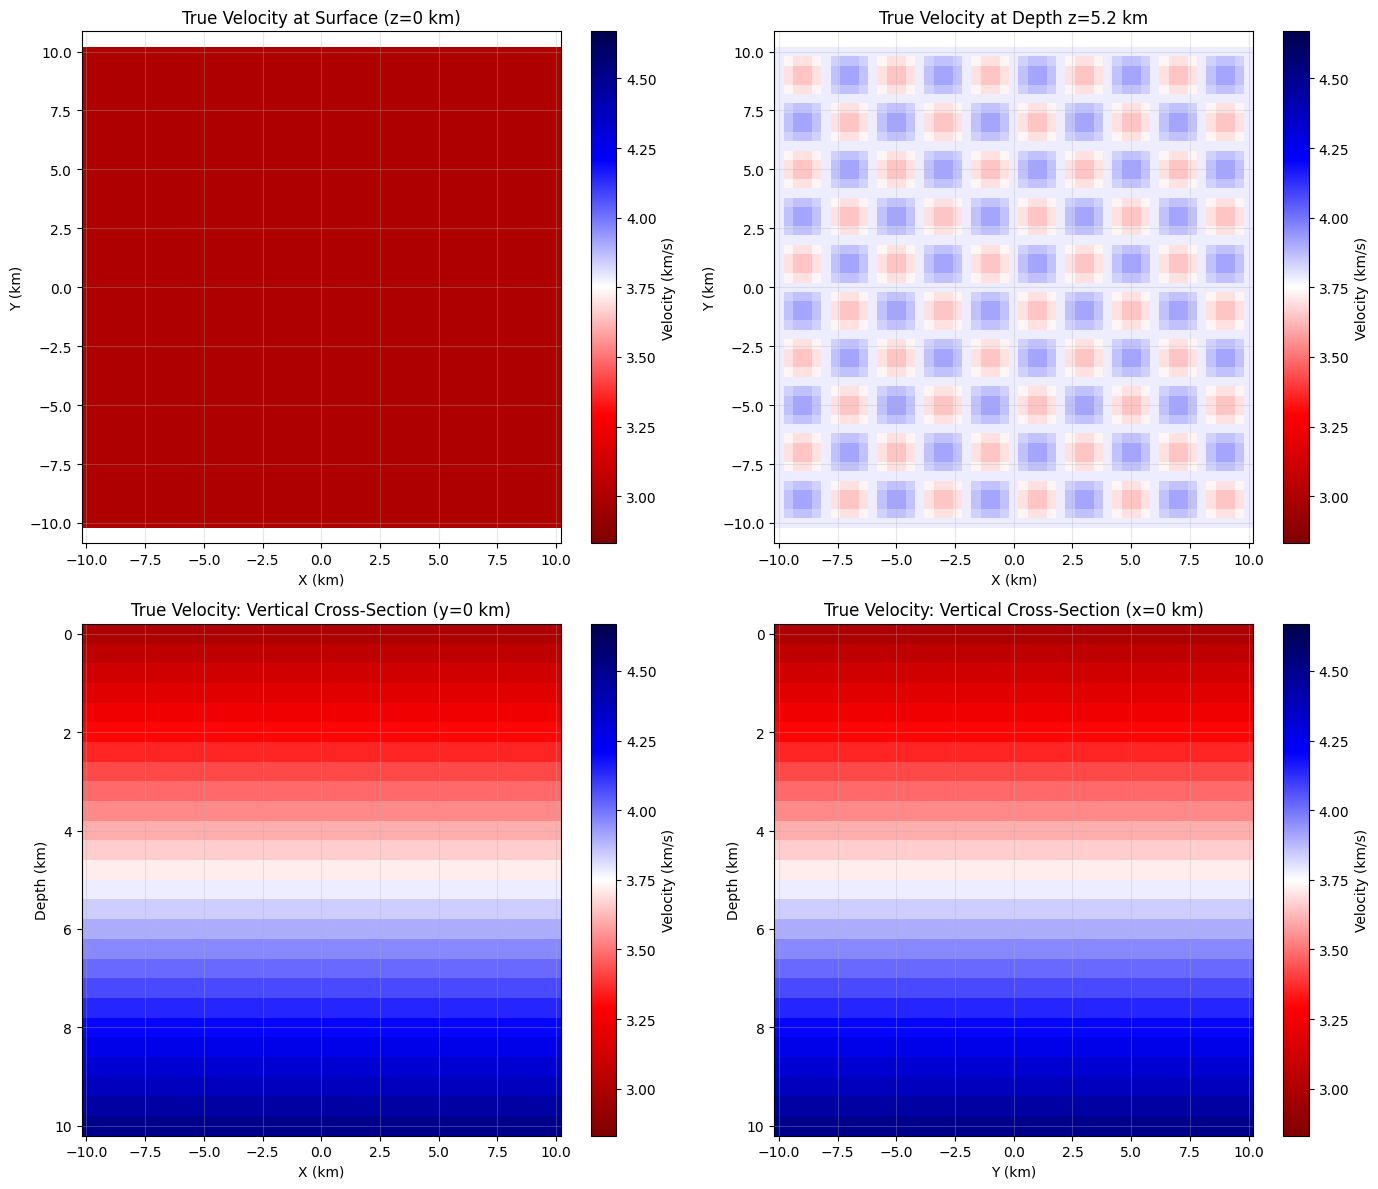

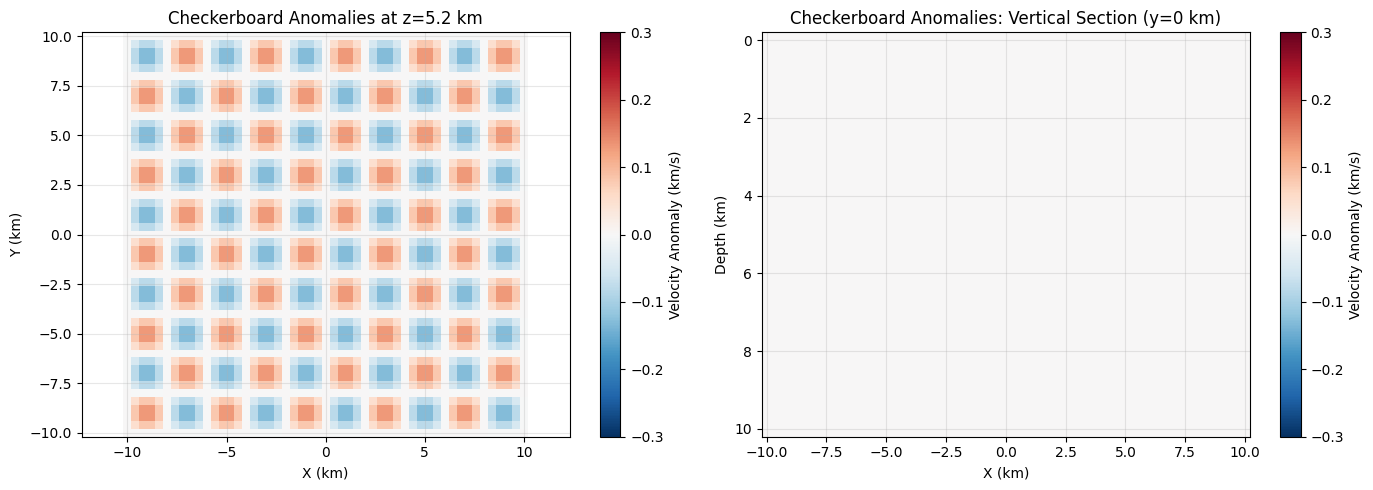

In [3]:
# Plot true velocity model slices
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Surface slice (z=0)
ax = axes[0, 0]
im = ax.pcolormesh(X[:, :, 0], Y[:, :, 0], velocity_true[:, :, 0], 
                   shading='auto', cmap='seismic_r', vmin=velocity_true.min(), vmax=velocity_true.max())
plt.colorbar(im, ax=ax, label='Velocity (km/s)')
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_title('True Velocity at Surface (z=0 km)')
ax.axis('equal')
ax.grid(True, alpha=0.3)

# Mid-depth slice (z=5 km)
ax = axes[0, 1]
mid_z_idx = nz // 2
im = ax.pcolormesh(X[:, :, mid_z_idx], Y[:, :, mid_z_idx], velocity_true[:, :, mid_z_idx], 
                   shading='auto', cmap='seismic_r', vmin=velocity_true.min(), vmax=velocity_true.max())
plt.colorbar(im, ax=ax, label='Velocity (km/s)')
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_title(f'True Velocity at Depth z={z[mid_z_idx]:.1f} km')
ax.axis('equal')
ax.grid(True, alpha=0.3)

# Vertical slice at y=0
ax = axes[1, 0]
y_mid_idx = ny // 2
im = ax.pcolormesh(X[:, y_mid_idx, :], Z[:, y_mid_idx, :], velocity_true[:, y_mid_idx, :], 
                   shading='auto', cmap='seismic_r', vmin=velocity_true.min(), vmax=velocity_true.max())
plt.colorbar(im, ax=ax, label='Velocity (km/s)')
ax.set_xlabel('X (km)')
ax.set_ylabel('Depth (km)')
ax.set_title('True Velocity: Vertical Cross-Section (y=0 km)')
ax.invert_yaxis()
ax.grid(True, alpha=0.3)

# Vertical slice at x=0
ax = axes[1, 1]
x_mid_idx = nx // 2
im = ax.pcolormesh(Y[x_mid_idx, :, :], Z[x_mid_idx, :, :], velocity_true[x_mid_idx, :, :], 
                   shading='auto', cmap='seismic_r', vmin=velocity_true.min(), vmax=velocity_true.max())
plt.colorbar(im, ax=ax, label='Velocity (km/s)')
ax.set_xlabel('Y (km)')
ax.set_ylabel('Depth (km)')
ax.set_title('True Velocity: Vertical Cross-Section (x=0 km)')
ax.invert_yaxis()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot checkerboard anomalies separately
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Horizontal slice of anomalies
ax = axes[0]
im = ax.pcolormesh(X[:, :, mid_z_idx], Y[:, :, mid_z_idx], 
                   checkerboard[:, :, mid_z_idx], 
                   shading='auto', cmap='RdBu_r', 
                   vmin=-checkerboard_amplitude, vmax=checkerboard_amplitude)
plt.colorbar(im, ax=ax, label='Velocity Anomaly (km/s)')
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_title(f'Checkerboard Anomalies at z={z[mid_z_idx]:.1f} km')
ax.axis('equal')
ax.grid(True, alpha=0.3)

# Vertical slice of anomalies
ax = axes[1]
im = ax.pcolormesh(X[:, y_mid_idx, :], Z[:, y_mid_idx, :], 
                   checkerboard[:, y_mid_idx, :], 
                   shading='auto', cmap='RdBu_r',
                   vmin=-checkerboard_amplitude, vmax=checkerboard_amplitude)
plt.colorbar(im, ax=ax, label='Velocity Anomaly (km/s)')
ax.set_xlabel('X (km)')
ax.set_ylabel('Depth (km)')
ax.set_title('Checkerboard Anomalies: Vertical Section (y=0 km)')
ax.invert_yaxis()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Define Earthquake Sources and Seismic Network

**Key consideration:** Ray path coverage determines what parts of the model we can resolve.

- **Receivers:** Surface network (similar to location exercise)
- **Sources:** Multiple earthquakes at various depths and locations
- **Progressive experiment:** Start with few events, then increase to see resolution improvement

In [5]:
# Define receiver array at surface (z=0) - similar to location exercise
sensor_spacing = 2.0  # km
x_sensors = np.arange(-8, 8.1, sensor_spacing)
y_sensors = np.arange(-8, 8.1, sensor_spacing)
X_sensors, Y_sensors = np.meshgrid(x_sensors, y_sensors)
Z_sensors = np.zeros_like(X_sensors)  # All at surface

# Flatten sensor coordinates
receiver_coords = np.column_stack([
    X_sensors.ravel(),
    Y_sensors.ravel(),
    Z_sensors.ravel()
])
n_receivers = len(receiver_coords)

print(f"Receiver Network:")
print(f"  Number of receivers: {n_receivers}")
print(f"  Receiver spacing: {sensor_spacing} km")
print(f"  All receivers at surface (z=0 km)")

# Define earthquake source locations (KNOWN positions for tomography)
# We'll create multiple scenarios with different numbers of sources

# Scenario 1: Sparse source distribution (few earthquakes)
np.random.seed(42)  # For reproducibility
n_sources_sparse = 10
source_coords_sparse = np.column_stack([
    np.random.uniform(x_min + 2, x_max - 2, n_sources_sparse),
    np.random.uniform(y_min + 2, y_max - 2, n_sources_sparse),
    np.random.uniform(2.0, 8.0, n_sources_sparse)  # Between 2-8 km depth
])

# Scenario 2: Moderate source distribution
n_sources_moderate = 25
source_coords_moderate = np.column_stack([
    np.random.uniform(x_min + 2, x_max - 2, n_sources_moderate),
    np.random.uniform(y_min + 2, y_max - 2, n_sources_moderate),
    np.random.uniform(2.0, 8.0, n_sources_moderate)
])

# Scenario 3: Dense source distribution (many earthquakes)
n_sources_dense = 50
source_coords_dense = np.column_stack([
    np.random.uniform(x_min + 2, x_max - 2, n_sources_dense),
    np.random.uniform(y_min + 2, y_max - 2, n_sources_dense),
    np.random.uniform(2.0, 8.0, n_sources_dense)
])

# Start with moderate distribution for main workflow
source_coords = source_coords_moderate
n_sources = n_sources_moderate

print(f"\nEarthquake Sources:")
print(f"  Number of sources (moderate): {n_sources}")
print(f"  Source depth range: 2.0 - 8.0 km")
print(f"  Total source-receiver pairs: {n_sources * n_receivers}")
print(f"\nAlternative scenarios available:")
print(f"  Sparse:   {n_sources_sparse} sources ({n_sources_sparse * n_receivers} pairs)")
print(f"  Moderate: {n_sources_moderate} sources ({n_sources_moderate * n_receivers} pairs)")
print(f"  Dense:    {n_sources_dense} sources ({n_sources_dense * n_receivers} pairs)")

Receiver Network:
  Number of receivers: 81
  Receiver spacing: 2.0 km
  All receivers at surface (z=0 km)

Earthquake Sources:
  Number of sources (moderate): 25
  Source depth range: 2.0 - 8.0 km
  Total source-receiver pairs: 2025

Alternative scenarios available:
  Sparse:   10 sources (810 pairs)
  Moderate: 25 sources (2025 pairs)
  Dense:    50 sources (4050 pairs)


### Visualize Source-Receiver Geometry

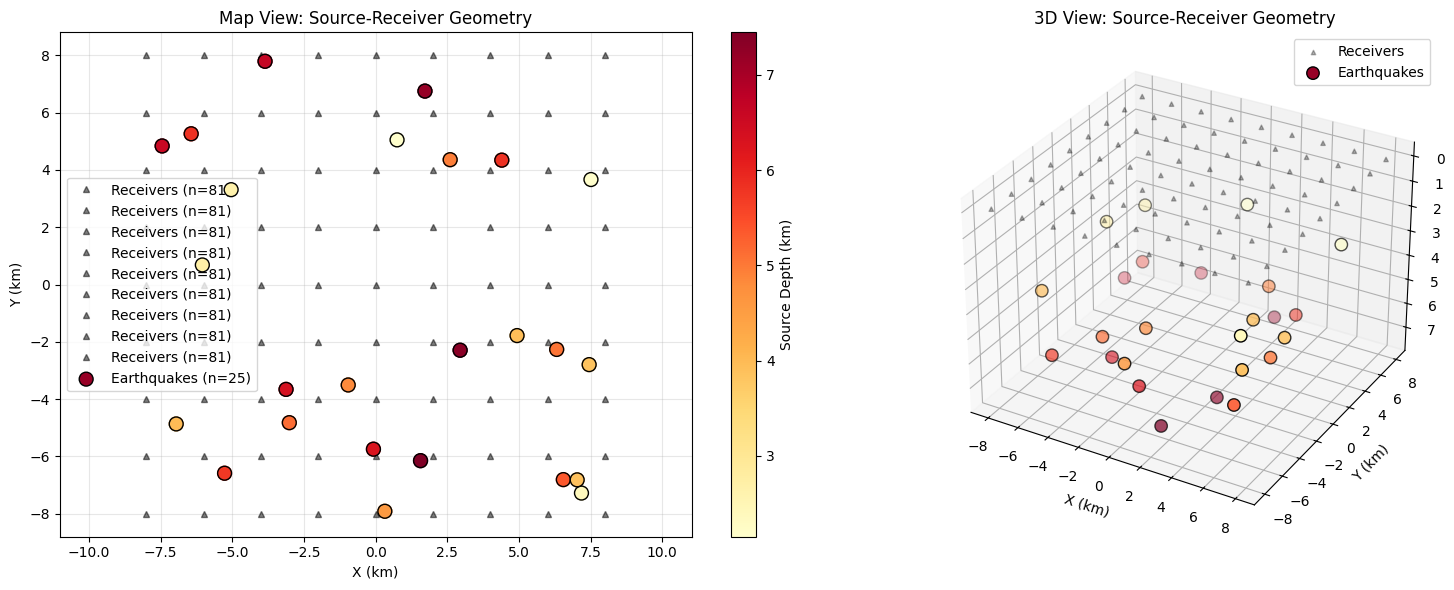

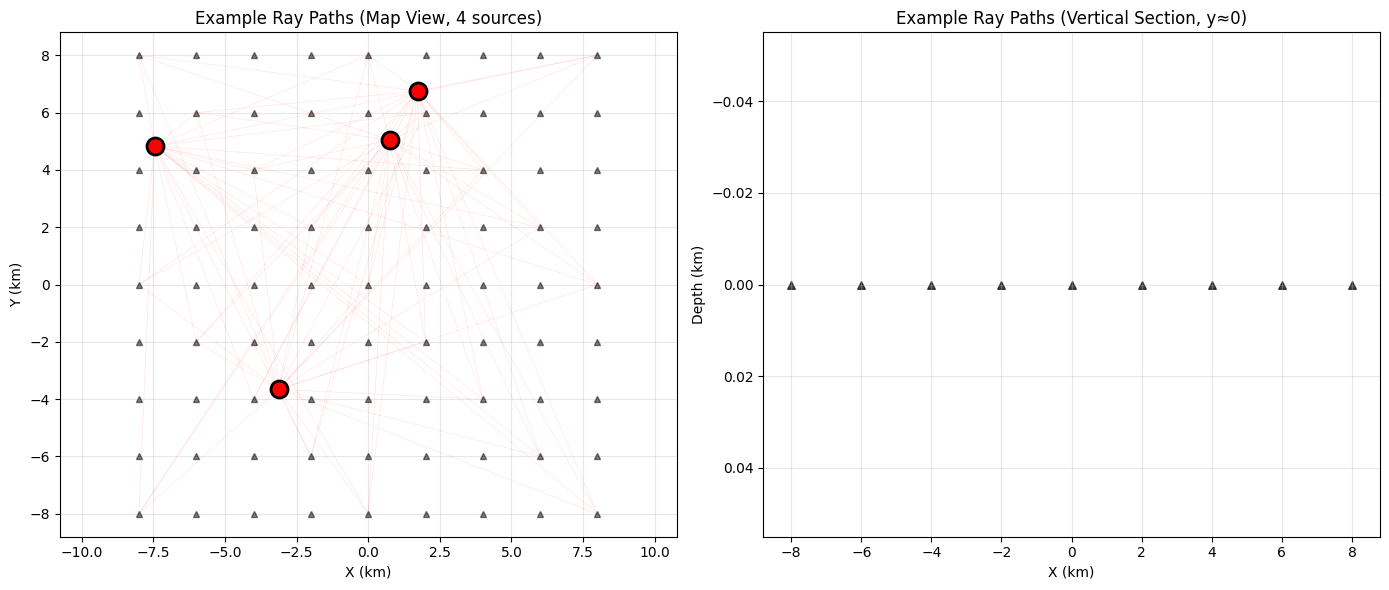


Ray path statistics:
  Total number of rays: 2025
  Average rays per source: 81
  Average rays per receiver: 25


In [6]:
# Visualize source-receiver geometry
fig = plt.figure(figsize=(16, 6))

# 2D map view
ax1 = fig.add_subplot(121)
ax1.plot(X_sensors, Y_sensors, 'k^', markersize=4, alpha=0.5, label=f'Receivers (n={n_receivers})')
ax1.scatter(source_coords[:, 0], source_coords[:, 1], 
           c=source_coords[:, 2], cmap='YlOrRd', 
           s=100, edgecolors='black', linewidths=1, 
           label=f'Earthquakes (n={n_sources})', zorder=10)
cbar = plt.colorbar(ax1.scatter(source_coords[:, 0], source_coords[:, 1], 
                                c=source_coords[:, 2], cmap='YlOrRd', s=100), 
                   ax=ax1, label='Source Depth (km)')
ax1.set_xlabel('X (km)')
ax1.set_ylabel('Y (km)')
ax1.set_title('Map View: Source-Receiver Geometry')
ax1.axis('equal')
ax1.grid(True, alpha=0.3)
ax1.legend()

# 3D view
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(X_sensors, Y_sensors, Z_sensors, c='black', marker='^', s=10, alpha=0.3, label='Receivers')
ax2.scatter(source_coords[:, 0], source_coords[:, 1], source_coords[:, 2], 
           c=source_coords[:, 2], cmap='YlOrRd', 
           s=80, edgecolors='black', linewidths=1, label='Earthquakes')
ax2.set_xlabel('X (km)')
ax2.set_ylabel('Y (km)')
ax2.set_zlabel('Depth (km)')
ax2.set_title('3D View: Source-Receiver Geometry')
ax2.invert_zaxis()
ax2.legend()

plt.tight_layout()
plt.show()

# Show example ray paths from a few sources
fig = plt.figure(figsize=(14, 6))

# Select a few sources to visualize rays
example_sources = [0, n_sources//4, n_sources//2, 3*n_sources//4]

ax1 = fig.add_subplot(121)
ax1.plot(X_sensors, Y_sensors, 'k^', markersize=4, alpha=0.5)
for i_src in example_sources:
    src = source_coords[i_src]
    # Draw lines from source to all receivers
    for rec in receiver_coords[::4]:  # Sample every 4th receiver for clarity
        ax1.plot([src[0], rec[0]], [src[1], rec[1]], 'r-', alpha=0.1, linewidth=0.5)
    ax1.scatter(src[0], src[1], s=150, c='red', edgecolors='black', 
               linewidths=2, zorder=10)
ax1.set_xlabel('X (km)')
ax1.set_ylabel('Y (km)')
ax1.set_title(f'Example Ray Paths (Map View, {len(example_sources)} sources)')
ax1.axis('equal')
ax1.grid(True, alpha=0.3)

# Vertical cross-section
ax2 = fig.add_subplot(122)
# Show rays in vertical plane at y=0
y_tol = 2.0  # Include receivers/sources within ±2 km of y=0
for i_src in example_sources:
    src = source_coords[i_src]
    if abs(src[1]) < y_tol:
        for rec in receiver_coords:
            if abs(rec[1]) < y_tol:
                ax2.plot([src[0], rec[0]], [src[2], rec[2]], 'r-', alpha=0.15, linewidth=0.5)
        ax2.scatter(src[0], src[2], s=150, c='red', edgecolors='black', 
                   linewidths=2, zorder=10)

# Plot receivers at surface
receivers_near_y0 = receiver_coords[np.abs(receiver_coords[:, 1]) < y_tol]
ax2.scatter(receivers_near_y0[:, 0], receivers_near_y0[:, 2], 
           c='black', marker='^', s=30, alpha=0.7)
ax2.set_xlabel('X (km)')
ax2.set_ylabel('Depth (km)')
ax2.set_title('Example Ray Paths (Vertical Section, y≈0)')
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nRay path statistics:")
print(f"  Total number of rays: {n_sources * n_receivers}")
print(f"  Average rays per source: {n_receivers}")
print(f"  Average rays per receiver: {n_sources}")

## 4. Forward Problem: Compute Synthetic Travel Times

For each earthquake-receiver pair, solve the eikonal equation through the **true** velocity model to generate synthetic observed data.

In [ ]:
# TODO: Loop over earthquakes
# TODO: For each earthquake, solve eikonal equation using PyKonal
# TODO: Extract travel times at all receivers
# TODO: Add realistic noise
# TODO: Store in data vector d_obs (N_observations × 1)

### Visualize Observed Data

In [ ]:
# TODO: Plot travel time vs. distance for each earthquake
# TODO: Show data coverage (which source-receiver pairs exist)

## 5. Tomography Inverse Problem: Theory

### 5.1 Linearization and the Fréchet Matrix

The forward relation is:
$$t_{ij} = \int_{\text{ray}} s(\mathbf{x}) \, dl$$
where $t_{ij}$ is the travel time from source $i$ to receiver $j$, and $s(\mathbf{x}) = 1/c(\mathbf{x})$ is slowness.

**Linearization:** Given a reference model $s_0(\mathbf{x})$ and perturbation $\delta s(\mathbf{x})$:
$$\delta t_{ij} \approx \int_{\text{ray}_0} \delta s(\mathbf{x}) \, dl$$
where the ray is computed in the reference model $s_0$ (ray path frozen).

**Discretization:** Parameterize slowness on a grid with $N_{\text{param}}$ cells:
$$\delta t_{ij} = \sum_{k=1}^{N_{\text{param}}} G_{ij,k} \, \delta s_k$$
where $G_{ij,k}$ is the **ray path length** through cell $k$ for source-receiver pair $(i,j)$.

In matrix form:
$$\mathbf{d} = G \mathbf{m}$$
- $\mathbf{d}$: travel-time residuals ($N_{\text{data}} \times 1$)
- $G$: Fréchet (design) matrix ($N_{\text{data}} \times N_{\text{param}}$)
- $\mathbf{m}$: slowness perturbations ($N_{\text{param}} \times 1$)

### 5.2 Building the Design Matrix

**Key steps:**
1. For each source-receiver pair, trace the ray through the current velocity model
2. Compute path length $L_k$ through each grid cell $k$
3. Set $G_{ij,k} = L_k$

**Properties:**
- $G$ is **very sparse** (most rays pass through only a small fraction of cells)
- $G$ is typically **rectangular** and **ill-conditioned** (many more parameters than data, or vice versa)
- Cells without ray coverage have all-zero columns → unresolvable

### 5.3 Solving the Inverse Problem

**Damped least squares:**
$$\hat{\mathbf{m}} = (G^T G + \epsilon^2 I)^{-1} G^T \mathbf{d}$$
where $\epsilon$ is the damping parameter (trades fit vs. model norm).

**Regularization:**
- **Damping:** Penalizes large velocity perturbations
- **Smoothing:** Penalizes rough models using finite-difference operators
- **Combined:** $\min_m \|Gm - d\|^2 + \epsilon^2\|m\|^2 + \alpha^2\|Lm\|^2$ where $L$ is a smoothing operator

**Iterative refinement:**
1. Start with initial model $c_0$ (e.g., depth-dependent average)
2. Compute predicted travel times $t_{ij}^{\text{pred}}$ using current model
3. Form residuals $d_{ij} = t_{ij}^{\text{obs}} - t_{ij}^{\text{pred}}$
4. Build $G$ matrix using rays traced through current model
5. Solve for slowness perturbation $\delta s$
6. Update model: $s_{\text{new}} = s_{\text{old}} + \alpha \delta s$ (with step length $\alpha$)
7. Repeat until convergence

### 5.4 Resolution and Uncertainty

**Model resolution matrix:**
$$R = (G^T G + \epsilon^2 I)^{-1} G^T G$$
Ideally $R = I$; deviations show smearing and leakage between parameters.

**Checkerboard test:**
A synthetic resolution test:
1. Create input model with alternating high/low velocity anomalies
2. Compute synthetic data using this model
3. Invert data using the same source-receiver geometry
4. Compare recovered model to input checkerboard
5. Well-resolved regions recover the pattern; poorly resolved regions show smearing/damping

**Data redundancy and rank:**
- Parallel or near-parallel rays are redundant (measure same structure)
- Crossing rays at different angles provide independent constraints
- Data covariance $C_d$ has reduced rank when rays are correlated
- Model null space: velocity perturbations that produce zero travel-time change

## 6. Initial (Starting) Velocity Model

Create a simple reference model to start the inversion (e.g., depth-dependent average, or homogeneous).

In [ ]:
# TODO: Define initial/background velocity model
# TODO: This is our starting point (v0), simpler than the true model
# TODO: Visualize initial model vs. true model

## 7. Build the Fréchet (Design) Matrix G

**Strategy:** Use PyKonal to trace rays and compute path lengths through each grid cell.

In [ ]:
# TODO: Define function to trace ray and compute path lengths
# TODO: Loop over all source-receiver pairs
# TODO: Fill sparse G matrix (N_data × N_param)
# TODO: Visualize G matrix sparsity pattern

### Analyze Design Matrix Properties

In [ ]:
# TODO: Check G matrix dimensions, sparsity
# TODO: Compute ray hit count per cell (shows coverage)
# TODO: Identify unsampled regions (all-zero columns in G)

## 8. Solve the Inverse Problem (Damped Least Squares)

Solve for slowness perturbations using regularized inversion.

In [ ]:
# TODO: Compute travel-time residuals (d_obs - d_pred)
# TODO: Set damping parameter epsilon
# TODO: Solve: m = (G^T G + eps^2 I)^{-1} G^T d  [or use lsqr]
# TODO: Convert slowness perturbation back to velocity perturbation
# TODO: Update velocity model

### Visualize Inverted Model (Single Iteration)

In [ ]:
# TODO: Plot recovered velocity model
# TODO: Compare to true model (residual/difference)
# TODO: Compute misfit reduction

## 9. Iterative Inversion

Repeat the inversion with updated model until convergence.

In [ ]:
# TODO: Implement iteration loop
# TODO: For each iteration:
#       - Compute predicted data using current model
#       - Build new G matrix (rays change as model updates)
#       - Solve for velocity update
#       - Apply update with step length control
#       - Track misfit vs. iteration
# TODO: Plot convergence curve

### Compare Final Model to True Model

In [ ]:
# TODO: Side-by-side plots: true vs. recovered velocity
# TODO: Compute correlation, RMS error
# TODO: Identify well-recovered vs. poorly-recovered regions

## 10. Resolution Analysis: Checkerboard Test

**Purpose:** Assess which parts of the model are well-resolved by the data.

**Method:**
1. Create synthetic checkerboard velocity model
2. Generate synthetic data using same source-receiver geometry
3. Invert data starting from smooth background
4. Examine recovery of checkerboard pattern

In [ ]:
# TODO: Create checkerboard velocity anomalies
# TODO: Compute synthetic travel times through checkerboard
# TODO: Invert using same workflow as above
# TODO: Visualize input vs. recovered checkerboard

### Interpret Checkerboard Results

In [ ]:
# TODO: Identify regions with good recovery (sharp checkerboard pattern)
# TODO: Identify smeared/damped regions (poor resolution)
# TODO: Relate poor resolution to lack of crossing ray paths

## 11. Explore Effect of Ray Path Coverage

**Experiment:** Start with few earthquakes, progressively add more, and observe resolution improvement.

In [ ]:
# TODO: Define scenarios with increasing number of earthquakes
#       - Scenario 1: 5 earthquakes
#       - Scenario 2: 15 earthquakes
#       - Scenario 3: 50 earthquakes
# TODO: For each scenario, invert data and compare recovery quality
# TODO: Plot model quality vs. number of sources

### Visualize Ray Coverage Evolution

In [ ]:
# TODO: Plot ray hit count maps for each scenario
# TODO: Show how adding sources fills in coverage gaps
# TODO: Relate coverage to model uncertainty

## 12. Data Covariance, Rank, and Redundancy

**Concepts:**
- **Parallel rays:** Provide redundant information (high correlation in data covariance)
- **Crossing rays:** Provide independent constraints (low correlation)
- **Rank deficiency:** Occurs when data contain less independent information than assumed

**Analysis:**
- Compute data covariance $C_d$ from residuals across multiple realizations
- Perform eigenvalue decomposition to assess effective rank
- Identify redundant vs. informative data components

In [ ]:
# TODO: Compute G^T G and analyze eigenvalues
# TODO: Plot eigenvalue spectrum (shows information content)
# TODO: Identify null space and poorly constrained modes
# TODO: Simulate data covariance for parallel vs. crossing ray scenarios

## 13. Model Uncertainty Quantification

**Approaches:**
- **Diagonal of model covariance:** $\text{diag}(C_m) = \text{diag}((G^T G + \epsilon^2 I)^{-1})$
- **Bootstrap:** Resample data and re-invert many times
- **Resolution matrix:** Examine diagonal and off-diagonal elements
- **Checkerboard amplitude recovery:** Ratio of recovered to input amplitude

In [ ]:
# TODO: Compute model covariance (or approximate diagonal)
# TODO: Plot uncertainty maps (standard deviation per cell)
# TODO: Overlay with ray hit count
# TODO: Confirm that uncertainty is high where coverage is low

## 14. Damping and Smoothing Trade-offs

**L-curve analysis:** Plot model norm vs. data misfit for various damping parameters to find optimal regularization.

In [ ]:
# TODO: Solve inversion for range of damping parameters
# TODO: Compute ||Gm - d||^2 (data misfit) and ||m||^2 (model norm)
# TODO: Plot L-curve
# TODO: Identify corner (optimal damping)

## 15. Summary and Discussion

### Key Results:

1. **Forward Problem:** Generated synthetic travel-time data from known velocity model
2. **Inverse Problem:** Iteratively recovered 3D velocity structure from travel times
3. **Resolution:** Used checkerboard tests to assess spatial resolution
4. **Coverage:** Demonstrated importance of crossing ray paths for good resolution
5. **Uncertainty:** Quantified model uncertainty and linked it to ray coverage

### Important Observations:

- **Resolution vs. Coverage:** Well-sampled regions (crossing rays) show better recovery
- **Iteration:** Nonlinear problem requires multiple iterations; rays change as model updates
- **Regularization:** Damping/smoothing essential to stabilize ill-posed problem
- **Checkerboard:** Direct visualization of what features can/cannot be resolved
- **Redundancy:** Parallel rays add little new information; crossing rays critical

### Extensions to Try:

1. **Realistic geology:** Replace checkerboard with subduction zone, sedimentary basin, etc.
2. **Joint inversion:** Simultaneously solve for velocity structure and earthquake locations
3. **Adaptive parameterization:** Use finer grid where resolution is good, coarser where poor
4. **Anisotropy:** Extend to azimuthally anisotropic velocity
5. **Attenuation tomography:** Invert amplitude data for Q structure
6. **Surface waves:** Add dispersion measurements for shallow structure

### Real-World Applications:

- **Regional tomography:** Crustal and upper mantle structure
- **Local tomography:** Volcano imaging, fault zone structure
- **Global tomography:** Whole-mantle heterogeneity, subducted slabs
- **Exploration geophysics:** Oil/gas reservoirs, mineral deposits
- **Engineering:** Site characterization, landslide imaging

## 16. Exercise Questions

1. **How does damping affect model recovery?**
   - Run inversions with very small and very large damping
   - Which produces better data fit? Which produces more realistic models?

2. **What is the minimum ray coverage needed?**
   - Remove sources progressively and observe when recovery fails
   - Is there a threshold number of crossing rays per cell?

3. **How do you choose checkerboard size?**
   - Try different checkerboard wavelengths (coarse vs. fine)
   - What happens when checkerboard is finer than resolvable scale?

4. **Does iteration converge?**
   - Plot misfit reduction vs. iteration number
   - When should you stop iterating?

5. **What about noise?**
   - Increase data noise level and observe effect on recovered model
   - Does regularization help mitigate noise?

6. **Can you detect the null space?**
   - Identify velocity perturbations that produce zero travel-time change
   - Relate to ray geometry (e.g., anomalies between ray paths)

7. **Sparse vs. dense networks:**
   - Compare recovery using a sparse receiver array vs. dense array
   - How does receiver spacing affect horizontal resolution?